# SYSID - Atividade 08

Aluno: Pedro Henrique Cardoso Paulo<br>

Professor: Helon

## Objetivo

Nessa atividade seguiremos a trilha da <a href="../Atividade06/Atividade06.ipynb">Atividade 06</a>, construindo aagora um modelo NARMAX.

## Passo 0 - Importando bibliotecas

In [1]:
#Desabilitando warnings
#def warn(*args, **kwargs):
#    pass
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
#warnings.warn = warn

# Pacotes padrao
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import datetime

#sysidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.general_estimators.narx import NARX
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

#Pipeline
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.model_selection import RandomizedSearchCV

# Scores
from sklearn.metrics import r2_score

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
data = np.genfromtxt('../data/robot_arm.dat')
X1 = data[:,0].reshape(-1,1)
y = data[:,1].reshape(-1,1)

### 0.2 - Visualizando dados

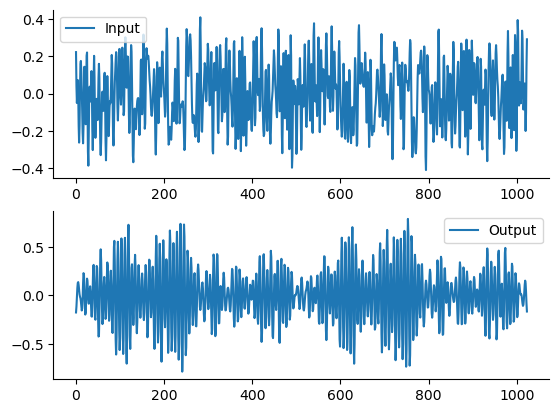

In [3]:
fig, ax = plt.subplots(2,1)
ax[0].plot(X1, label='Input')
ax[1].plot(y, label='Output')
ax[0].legend()
ax[1].legend()

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [4]:
p_train = 0.5 #50% treino

### 1.2 - Separando os conjuntos

In [5]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

In [6]:
print(
    X1_tr.shape,
    X1_te.shape
)

(512, 1) (512, 1)


## Passo 2 - Iniciando a construção do modelo ARMAX/NARMAX

Para essa atividade, vamos usar a biblioteca sysidentpy. Essa biblioteca guarda grandes similaridades com bibliotecas da área de machine learning, como `scikit-learn`, `tensorflow` e `pytorch`.
Como na <a href="../Atividade06/Atividade06.ipynb">Atividade 06</a> o modelo que usamos de base mostrou-se divergente para a simulação livre, vamos aqui tentar propor um modelo ligeiramente diferente de base, com `na = nb = 6`. Além disso, vamos adicionar 4 termos não-lineares por padrão nos coeficientes do ajuste por meio do parâmetro n_terms.

### 2.1 - Selecionando a arquitetura (NARMAX)

Para esse caso, como o númeroo de termos tende a crescer muito, vamos deixar o sysidentpy selecionar a ordem de nossos modelos

In [7]:
basis_function = Polynomial(degree=2)
na = 6
nb = 6
ne = 1
n_extra = 4
model_NARMAX = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    n_terms=na+nb+ne+n_extra,
    model_type='NARMAX',
    extended_least_squares=True,
)

### 2.3 - Selecionando arquitetura (ARMAX)

In [8]:
basis_function = Polynomial(degree=1)
na = 6
nb = 6
ne = 1
model_ARMAX = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    n_terms=na+nb+ne,
    model_type='NARMAX',
    extended_least_squares=True,
)

## Passo 3 - Realizando ajuste inicial

### 3.1 - Performando o ajuste

In [9]:
model_NARMAX.fit(X=X1_tr, y=y_tr)
model_ARMAX.fit(X=X1_tr, y=y_tr)

### 3.2 - Visualizando os resultados (NARMAX)

In [10]:
r = pd.DataFrame(
    results(
        model_NARMAX.final_model, model_NARMAX.theta, model_NARMAX.err,
        model_NARMAX.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-4),-3.2019E-01,8.82401672E-01
1,x1(k-2),1.6288E+00,3.29600726E-02
2,y(k-1),2.1097E+00,1.02592690E-02
3,y(k-2),-1.5122E+00,6.85312782E-02
4,y(k-3),1.3780E-01,5.50065803E-03
5,y(k-5),1.0195E+00,1.64955708E-04
6,y(k-6),-6.6042E-01,1.37292568E-04
7,x1(k-6),4.1726E-02,2.65253626E-06
8,x1(k-5),-6.8207E-01,2.07900544E-06
9,x1(k-4),1.7396E+00,3.89195334E-07


### 3.3 - Visualizando os resultados (ARMAX)

In [11]:
r = pd.DataFrame(
    results(
        model_ARMAX.final_model, model_ARMAX.theta, model_ARMAX.err,
        model_ARMAX.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-4),-3.5674E-01,8.82401672E-01
1,x1(k-2),1.6296E+00,3.29600726E-02
2,y(k-1),2.0962E+00,1.02592690E-02
3,y(k-2),-1.4862E+00,6.85312782E-02
4,y(k-3),1.3358E-01,5.50065803E-03
5,y(k-5),1.0620E+00,1.64955708E-04
6,y(k-6),-6.7713E-01,1.37292568E-04
7,x1(k-6),3.6547E-02,2.65253626E-06
8,x1(k-5),-6.6965E-01,2.07900544E-06
9,x1(k-4),1.7263E+00,3.89195334E-07


### 3.4 - Comentários

Nota-se ao olharmos os valores do ajuste que os coeficientes lineares ficam sendo os de maior peso em ambos os casos. Além disso, a ordem dos coeficientes lineares em ambos os ajustes é a mesma, de modo que é esperado que os ajustes fiquem bem próximos, com os coeficientes lineares sendo os dominantes e pouco ganho n aplicação do NARMAX.

## Passo 4 - Comparando os resultados

### 4.1 - Calculando predição OSA

In [12]:
y_tr_pr_OSA_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=1)

y_tr_pr_OSA_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=1)

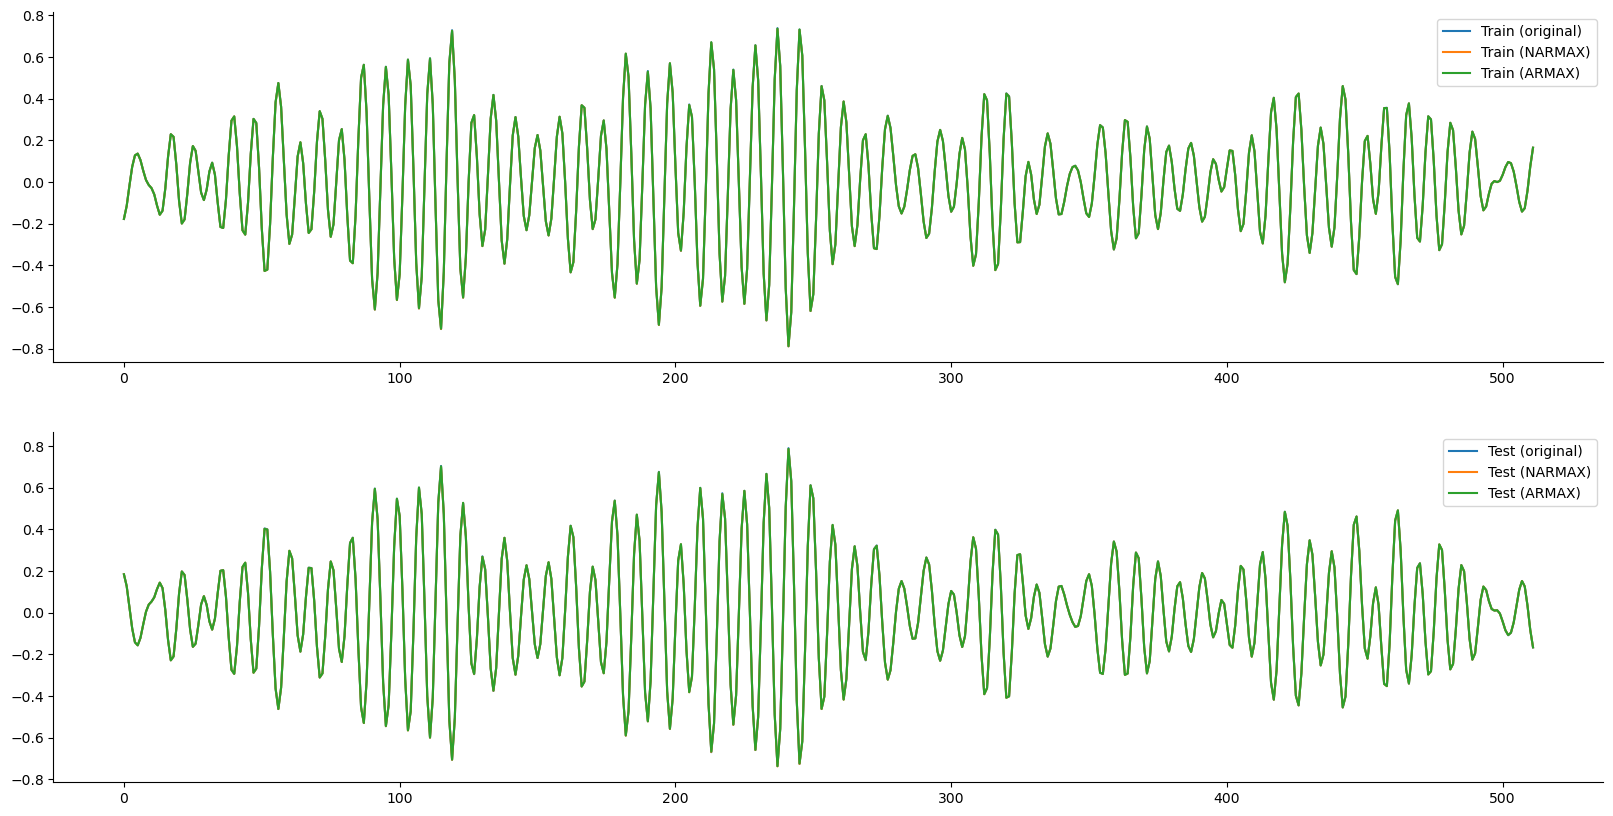

In [13]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_OSA_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_OSA_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_OSA_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_OSA_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [14]:
print('ARMAX Results:')
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_OSA_ARMAX))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_OSA_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_OSA_NARMAX))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_OSA_NARMAX))

ARMAX Results:
R2 score for OSA prediction (train) : 0.9999892639183349
R2 score for OSA prediction (test)  : 0.9999868031285237

NARMAX Results:
R2 score for OSA prediction (train) : 0.9999889161115764
R2 score for OSA prediction (test)  : 0.999986826963179


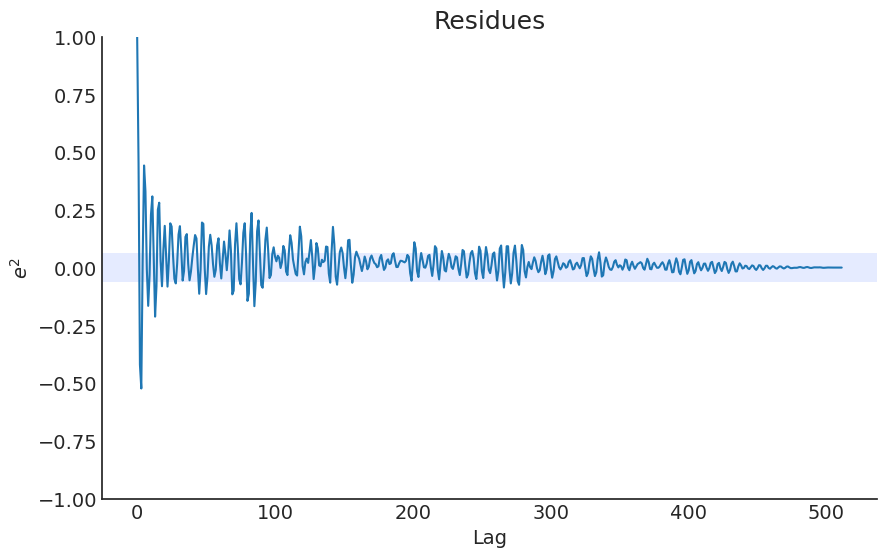

In [15]:
ee = compute_residues_autocorrelation(y_tr, y_tr_pr_OSA_NARMAX)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

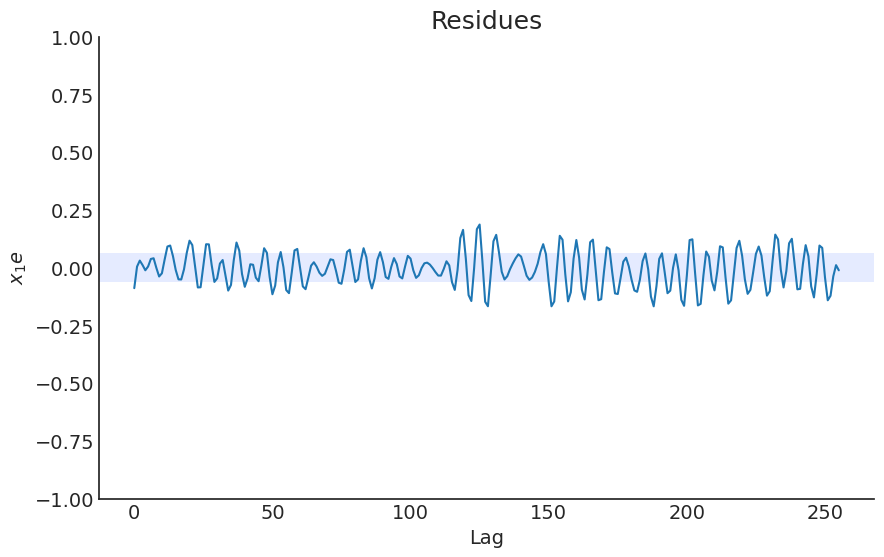

In [16]:
x1e = compute_cross_correlation(y_tr, y_tr_pr_OSA_NARMAX, X1_tr)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

### 4.3 - Calculando predição FS

In [17]:
y_tr_pr_FS_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=None)
y_te_pr_FS_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=None)
y_tr_pr_FS_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=None)
y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=None)

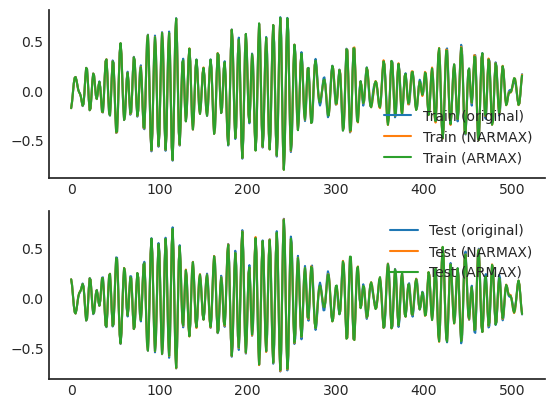

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_FS_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_FS_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [19]:
print('ARMAX Results:')
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_FS_ARMAX))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_FS_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_FS_NARMAX))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_FS_NARMAX))

ARMAX Results:
R2 score for OSA prediction (train) : 0.996776978688868
R2 score for OSA prediction (test)  : 0.994628739455621

NARMAX Results:
R2 score for OSA prediction (train) : 0.9955226372754635
R2 score for OSA prediction (test)  : 0.9941477565794615


## Passo 5 - Conclusões

* Comparado com o modelo ARMAX da <a href="../Atividade06/Atividade06.ipynb">Atividade 06</a>, os modelos aqui propostos não divergem na simulação livre com o acréscimo de dois pontos de atraso em y
* Os valores de $R^2$ para ambos os modelos ficaram altíssimos, tanto na simulação OSA quanto na FS
* Os testes eestatísticos ficaram similares em qualidade aos performados na <a href="../Atividade06/Atividade06.ipynb">Atividade 06</a>, com ligeira piora para o teste do $e^2$ e ligeira melhora para o do $ue$
    * Esses testes são impactados pelo número de termos não-lineares adicionados na resposta. Algumas sensibilidades foram feitas no notebook com 10, 15 e 20 termos a mais, com pouca variação em termos qualitativos
    * A adição de termos não-lineares também afeta a FS, podendo levar a resultados ligeiramente piores. Não necessariamente uma melhoria no teste estatístico implica em uma melhor FS
* Não houve ganho notável com a adoção do NARMAX para esse caso
    * A alta ordem do modelo já pareceu suficiente para um ajuste adequado
    * Termos lineares domminaram o ajuste